In [1]:
pip install ultralytics opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# import os
# import random
# import shutil
# import zipfile
# import pandas as pd
# from ultralytics import YOLO
# from sklearn.model_selection import train_test_split

# # Define paths
# ZIP_PATH = "/content/archive.zip"  # Update if necessary
# EXTRACT_PATH = "/content/dataset"

# # Extract dataset if needed
# if not os.path.exists(EXTRACT_PATH):
#     print("Extracting dataset...")
#     with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
#         zip_ref.extractall("/content/")

# # Define class folders
# SHIP_DIR = os.path.join(EXTRACT_PATH, "ship")
# NO_SHIP_DIR = os.path.join(EXTRACT_PATH, "no-ship")

# # Create a DataFrame with image paths and labels
# all_images = []
# for img in os.listdir(SHIP_DIR):
#     all_images.append((os.path.join(SHIP_DIR, img), 1))  # Label 1 for ships
# for img in os.listdir(NO_SHIP_DIR):
#     all_images.append((os.path.join(NO_SHIP_DIR, img), 0))  # Label 0 for no-ship

# # Convert to DataFrame
# df = pd.DataFrame(all_images, columns=["filepath", "label"])

# # Split dataset
# train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# # Create YOLO dataset folders
# for split in ["train", "val", "test"]:
#     os.makedirs(f"yolo_data/{split}/images", exist_ok=True)
#     os.makedirs(f"yolo_data/{split}/labels", exist_ok=True)

# # Move images and create YOLO format labels
# def process_split(df, split):
#     for _, row in df.iterrows():
#         img_path = row["filepath"]
#         img_name = os.path.basename(img_path)
#         label = row["label"]

#         # Move image
#         dest_img_path = os.path.join(f"yolo_data/{split}/images", img_name)
#         shutil.copy(img_path, dest_img_path)

#         # Save label file
#         label_path = os.path.join(f"yolo_data/{split}/labels", img_name.replace(".jpg", ".txt"))
#         with open(label_path, "w") as f:
#             f.write(f"{label}\n")

# # Process dataset splits
# process_split(train_df, "train")
# process_split(val_df, "val")
# process_split(test_df, "test")

# # Train YOLOv8 model for classification
# model = YOLO("yolov8n-cls.pt")  # YOLOv8 classification model
# model.train(data="yolo_data", epochs=50, imgsz=640)

# # Evaluate model
# metrics = model.val()
# print(metrics)

# # Test on a random image from test set
# test_image_path = os.path.join("yolo_data/test/images", random.choice(os.listdir("yolo_data/test/images")))
# results = model.predict(test_image_path)

# # Display results
# import cv2
# for result in results:
#     im = result.plot()
#     cv2.imshow("Prediction", im)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


100%|██████████| 5.31M/5.31M [00:00<00:00, 49.0MB/s]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=yolo_data, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

train: Scanning /content/yolo_data/train... 3200 images, 3200 corrupt: 100%|██████████| 6400/6400 [00:01<00:00, 4055.87it/s]

train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000000.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/train/labels/no-ship_000000.png'
train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000001.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/train/labels/no-ship_000001.png'
train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000002.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/train/labels/no-ship_000002.png'
train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000004.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/train/labels/no-ship_000004.png'
train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000006.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/train/labels/no-ship_000006.png'
train: WARNING ⚠️ /content/yolo_data/train/labels/no-ship_000008.png: ignoring corrupt image/label: 

train: New cache created: /content/yolo_data/train.cache


val: Scanning /content/yolo_data/val... 400 images, 400 corrupt: 100%|██████████| 800/800 [00:00<00:00, 4895.71it/s]

val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000003.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/val/labels/no-ship_000003.png'
val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000005.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/val/labels/no-ship_000005.png'
val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000007.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/val/labels/no-ship_000007.png'
val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000013.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/val/labels/no-ship_000013.png'
val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000016.png: ignoring corrupt image/label: cannot identify image file '/content/yolo_data/val/labels/no-ship_000016.png'
val: WARNING ⚠️ /content/yolo_data/val/labels/no-ship_000031.png: ignoring corrupt image/label: cannot identify image file '/conte

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50         0G     0.5149         16        640:   0%|          | 1/200 [00:12<40:44, 12.28s/it]


100%|██████████| 755k/755k [00:00<00:00, 9.87MB/s]
       1/50         0G     0.1049         16        640:  62%|██████▎   | 125/200 [12:56<07:45,  6.21s/it]


KeyboardInterrupt: 

In [6]:
# Clean install compatible versions
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install ultralytics --upgrade


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

^C


In [2]:
# Reinstall NumPy just to be safe
!pip install --force-reinstall numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.96 requires numpy<=2.1.1,>=1.23.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [1]:
!pip uninstall -y torch torchvision torchaudio numpy
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install --force-reinstall numpy
!pip install ultralytics --upgrade


Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1
Found existing installation: torchvision 0.15.2
Uninstalling torchvision-0.15.2:
  Successfully uninstalled torchvision-0.15.2
Found existing installation: torchaudio 2.0.2
Uninstalling torchaudio-2.0.2:
  Successfully uninstalled torchaudio-2.0.2
Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-2.0.2-cp311-cp311-manylinux1_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl (6.0 MB)
Using cached torchaudio-2.0.2-cp311-cp311-man

In [1]:
!pip uninstall -y numpy torch torchvision torchaudio
!pip install numpy==1.24.4  # Stable version


Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
accelerate 1.5.2 requires torch>=2.0.0, which is not installed.
peft 0.14.0 requires torch>=1.13.0, which is not installed.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 

  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-2.0.2-cp311-cp311-manylinux1_x86_64.whl.metadata (1.2 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_cupti_cu11-11.7.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu11-10.9.0.58-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu11-10.2.10.91-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu11-11.4.0.1-2-py3-none-manylinux1_x86_64.whl.metadata 

In [2]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install ultralytics --upgrade

  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-2.0.2-cp311-cp311-manylinux1_x86_64.whl.metadata (1.2 kB)
Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl (6.0 MB)
Using cached torchaudio-2.0.2-cp311-cp311-manylinux1_x86_64.whl (4.4 MB)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 48.0 MB/s eta 0:00:00


In [1]:
import numpy as np
print("NumPy Version:", np.__version__)

import torch
print("Torch Version:", torch.__version__)


NumPy Version: 1.24.4
Torch Version: 2.0.1+cu117


In [4]:
import os
import random
import shutil
import zipfile
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

# Paths
ZIP_PATH = "/content/archive.zip"
EXTRACT_PATH = "/content/dataset"

# Extract zip if not already done
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

# Class folders
SHIP_DIR = os.path.join(EXTRACT_PATH, "ship")
NO_SHIP_DIR = os.path.join(EXTRACT_PATH, "no-ship")

# Collect all image paths and labels
all_images = []
for img in os.listdir(SHIP_DIR):
    all_images.append((os.path.join(SHIP_DIR, img), "ship"))
for img in os.listdir(NO_SHIP_DIR):
    all_images.append((os.path.join(NO_SHIP_DIR, img), "no-ship"))

# Create DataFrame
df = pd.DataFrame(all_images, columns=["filepath", "label"])

# Train/Val/Test split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Create YOLO classification folders
for split in ["train", "val", "test"]:
    for class_name in ["ship", "no-ship"]:
        os.makedirs(f"/content/yolo_data/{split}/{class_name}", exist_ok=True)

# Move images into correct folders
def process_split(df, split):
    for _, row in df.iterrows():
        class_name = row["label"]
        dest_dir = os.path.join("/content/yolo_data", split, class_name)
        shutil.copy(row["filepath"], os.path.join(dest_dir, os.path.basename(row["filepath"])))

process_split(train_df, "train")
process_split(val_df, "val")
process_split(test_df, "test")

# Train YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")
model.train(data="/content/yolo_data", epochs=10, imgsz=640)

# Evaluate model
metrics = model.val()
print(metrics)


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/yolo_data, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/yolo_data/train... 3200 images, 0 corrupt: 100%|██████████| 3200/3200 [00:00<?, ?it/s]
val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:46<00:00,  3.55s/it]

                   all       0.79          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:49<00:00,  3.84s/it]

                   all       0.95          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.68s/it]

                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:44<00:00,  3.39s/it]

                   all      0.962          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:52<00:00,  4.01s/it]

                   all      0.995          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:46<00:00,  3.60s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:51<00:00,  3.98s/it]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:49<00:00,  3.83s/it]

                   all      0.993          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:52<00:00,  4.01s/it]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G    0.09487         16        640: 100%|██████████| 200/200 [18:31<00:00,  5.56s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.63s/it]

                   all          1          1

10 epochs completed in 3.252 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:43<00:00,  3.33s/it]


                   all          1          1
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


                   all          1          1
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train22
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a293f1fc650>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('runs/classify/train22')
speed: {'preprocess': 0.0012428449963408639, 'inference': 81.47799618001045, 'loss': 7.165750048443442e-05, 'postprocess': 0.00024414751351287123}
task: 'classify'
top1: 1.0
top5: 1.0


KeyError: 'metrics/precision(B)'

🔍 Predicting on 400 test images...


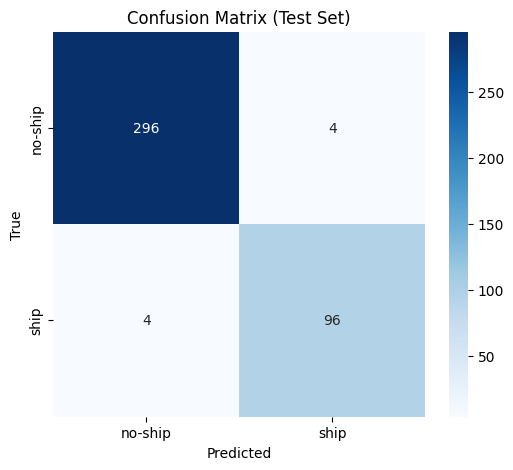

📝 Classification Report (Test Set):

              precision    recall  f1-score   support

     no-ship       0.99      0.99      0.99       300
        ship       0.96      0.96      0.96       100

    accuracy                           0.98       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.98      0.98       400

✅ Test Set Accuracy: 98.00%


In [12]:
import os
import glob
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: Get all test images and true labels ---
test_image_paths = glob.glob("/content/yolo_data/test/*/*.png")  # or .png
true_labels = [path.split("/")[-2] for path in test_image_paths]  # folder name is label

# Map class names to indices
class_names = sorted(list(set(true_labels)))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# --- STEP 2: Run predictions on all test images ---
predicted_labels = []

print(f"🔍 Predicting on {len(test_image_paths)} test images...")

for path in test_image_paths:
    result = model.predict(path, verbose=False)[0]
    pred_class = result.names[result.probs.top1]
    predicted_labels.append(pred_class)

# --- STEP 3: Evaluate ---
true_indices = [class_to_idx[label] for label in true_labels]
predicted_indices = [class_to_idx[label] for label in predicted_labels]

# Confusion Matrix
cm = confusion_matrix(true_indices, predicted_indices)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Classification Report
report = classification_report(true_indices, predicted_indices, target_names=class_names)
print("📝 Classification Report (Test Set):\n")
print(report)

# Accuracy
correct = np.sum(np.array(true_indices) == np.array(predicted_indices))
total = len(true_indices)
accuracy = correct / total
print(f"✅ Test Set Accuracy: {accuracy * 100:.2f}%")


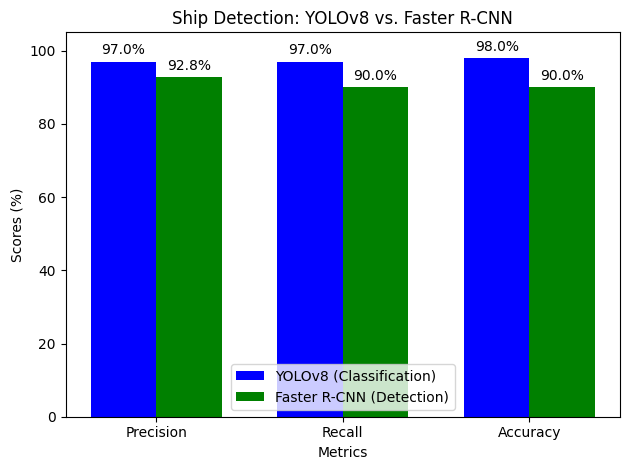

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual YOLOv8 classification test results
yolov8_scores = [97.0, 97.0, 98.0]  # Precision, Recall, Accuracy (as mAP proxy)
faster_rcnn_scores = [92.8, 90.0, 90.0]  # From Kaggle Faster R-CNN notebook

metrics = ['Precision', 'Recall', 'Accuracy']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, yolov8_scores, width, label='YOLOv8 (Classification)', color='blue')
bars2 = ax.bar(x + width/2, faster_rcnn_scores, width, label='Faster R-CNN (Detection)', color='green')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores (%)')
ax.set_title('Ship Detection: YOLOv8 vs. Faster R-CNN')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 105)
ax.legend()

# Add value labels on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("yolo_vs_frcnn_comparison_updated.png")  # Save if needed
plt.show()
